# Premiers Tests

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk import WordNetLemmatizer
from nltk import word_tokenize
import spicy

In [2]:
with open('data/s/train_s.jsonl', 'r') as f:
  a = list(f)

data_s =[]
for element in a:
  data_s.append(json.loads(element))

data_s = pd.DataFrame(data_s)

In [136]:
data_s.head(3)

,qID,sentence,option1,option2,answer,cluster,cos,dist,lemmatized_sentence,cluster2,sentence_bow
0,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-2,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,2,171,0.000000,0.000000,Ian volunteer to eat Dennis menudo after alrea...,0,"[ian, volunteer, eat, dennis, menudo, already,..."
1,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-1,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,1,171,0.950838,0.443452,Ian volunteer to eat Dennis menudo after alrea...,0,"[ian, volunteer, eat, dennis, menudo, already,..."
2,3XWUWJ18TLO2DDRXF83QWLKRJ29UU4-1,"He never comes to my home, but I always go to ...",home,house,1,126,1.513567,2.438387,He never come to my home but I always go to hi...,2,"[he, never, come, home, i, always, go, house, ..."


### $1^{ère}$ métrique : Clustering KMeans sur matrice de TDIDF

Obtention d'une matrice de TF-IDF puis clustering avec KMeans cette matrice (2 cas : lemmatisées ou non)
Remarque sur les clusters obtenus:
- Ils ne sont pas très pertinents (pas logique sémantique dans le cluster)
- Ils ne sont pas impactés par la lemmatisation

Remarque sur les plots de distortions, inerties :
- Clusters optimaux pour envrion $n_{clusters} = 300$ (résultat logique car on retrouve approximativement 320 schéma "soeur" dans la base de données)

In [4]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_s['sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [138]:
clustering = KMeans(n_clusters=200)
clusters = clustering.fit_predict(df)
data_s['Cluster'] = clusters

In [145]:
data_s[data_s['cluster']==0]['sentence']

398    Have you ever been on  a nature walk Samantha ...
399    Have you ever been on  a nature walk Samantha ...
Name: sentence, dtype: object

In [17]:
def sentence_lemmatizer(sentence):
  WNL = WordNetLemmatizer()
  lemmatized=[]
  for word in word_tokenize(sentence):
    if word.isalpha():
      lemms = [WNL.lemmatize(word,pos=f'{param}') for param in ['v','n','a','r','s']]
      ind = np.argmin([len(lemm) for lemm in lemms])
      lemmatized.append(lemms[ind])
  return ' '.join(lemmatized)

In [20]:
data_s['lemmatized_sentence'] = data_s['sentence'].apply(sentence_lemmatizer)

In [142]:
data_s.head(2)

,qID,sentence,option1,option2,answer,cluster,cos,dist,lemmatized_sentence,cluster2,sentence_bow,Cluster
0,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-2,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,2,171,0.000000,0.000000,Ian volunteer to eat Dennis menudo after alrea...,0,"[ian, volunteer, eat, dennis, menudo, already,...",152
1,3QHITW7OYO7Q6B6ISU2UMJB84ZLAQE-1,Ian volunteered to eat Dennis's menudo after a...,Ian,Dennis,1,171,0.950838,0.443452,Ian volunteer to eat Dennis menudo after alrea...,0,"[ian, volunteer, eat, dennis, menudo, already,...",152


In [141]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(data_s['lemmatized_sentence'])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df2 = pd.DataFrame(denselist,columns=feature_names)

c:\users\marti\work\lattice-internship\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [143]:
clustering = KMeans(200)
clusters = clustering.fit_predict(df2)
data_s['cluster2']= clusters

In [146]:
data_s[data_s['cluster2']==0]['sentence']

396    It took Jerry longer to shampoo his hair than ...
397    It took Jerry longer to shampoo his hair than ...
448    Jason's leg was more sore than his arm was bec...
449    Jason's leg was more sore than his arm was alt...
Name: sentence, dtype: object

In [45]:
distortions = []
inertias = []
from scipy.spatial.distance import cdist
K = range(1, 500)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df2)
    kmeanModel.fit(df2)

    distortions.append(sum(np.min(cdist(df2, kmeanModel.cluster_centers_,'euclidean'), axis=1)) / df2.shape[0])
    inertias.append(kmeanModel.inertia_)

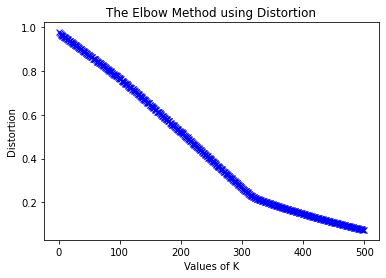

In [46]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

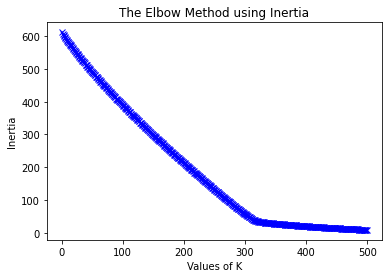

In [47]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Topic Modeling

La LDA sépare les phrases "soeurs" $\rightarrow$ il distingue donc la différence de sens entre ces phrases, malgré leur proximité lexicale

In [66]:
from nltk.corpus import stopwords
import gensim
from gensim.corpora import Dictionary

In [87]:
def topic_modeling_preprocessing(sentence):
    WNL = WordNetLemmatizer()
    bow = [word.lower() for word in word_tokenize(sentence) if not word in stopwords.words('english')]
    preprocessed_bow = []
    for word in bow:
        if word.isalpha():
            lemms = [WNL.lemmatize(word,pos=f'{param}') for param in ['v','n','a','r','s']]
            ind = np.argmin([len(lemm) for lemm in lemms])
            preprocessed_bow.append(lemms[ind])
    return preprocessed_bow

In [88]:
data_s['sentence_bow'] = [topic_modeling_preprocessing(sentence) for sentence in list(data_s['sentence'])]

In [110]:
dictionary = Dictionary(list(data_s['sentence_bow']))
bow_corpus = [dictionary.doc2bow(doc) for doc in list(data_s['sentence_bow'])]

n_topics= 90
lda = gensim.models.LdaMulticore(bow_corpus,num_topics=n_topics,id2word=dictionary)

In [115]:
ex_list = [element[0] for element in lda.get_topic_terms(15)]
for element in ex_list:
    if element <= 640:
        print(data_s.iloc[element]['sentence'])
        print('----------')

Brian had a large collection of coins that Kevin really admired, so _ offered him some duplicates.
----------
The employees threw a party and drank so much alcohol that they could not go into work the next day. The _ was loud.
----------
To overcome behavioural bias, we need to focus more on changing the conscious actions instead of the unconscious actions because the _ actions are voluntary.
----------
Jessica took off the gloves and gave them to Katrina because _ 's hands were cold.
----------
Chess is bad for the body but great for the brain, as thinking is useless for the _ to develop.
----------
The experience was totally unforgettable for Betty but not Samantha because _ had anticipated it for months.
----------
Ben had to either stop eating chocolates or nuts. He chose to stop eating the _ because they were savory.
----------
The couple drank wine out of glasses instead of mugs, because the _ were clean.
----------


In [ ]:
dictionary = Dictionary(list(data_s['s']))

In [119]:
from gensim.models import CoherenceModel
# Compute Coherence Score
list_coherence = []
for i in range(1,50):
    if i%5 == 0:
        print(i)
    lda_model = lda = gensim.models.LdaMulticore(bow_corpus,
                                                 num_topics=i,
                                                 id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=list(data_s['sentence_bow']),
                                         dictionary=dictionary,
                                         coherence='c_v')
    list_coherence.append(coherence_model_lda.get_coherence())

5
10
15
20
25
30
35
40
45


In [121]:
for i in range(51,70):
    if i%5 == 0:
        print(i)
    lda_model = lda = gensim.models.LdaMulticore(bow_corpus,
                                                 num_topics=i,
                                                 id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=list(data_s['sentence_bow']),
                                         dictionary=dictionary,
                                         coherence='c_v')
    list_coherence.append(coherence_model_lda.get_coherence())

55
60
65


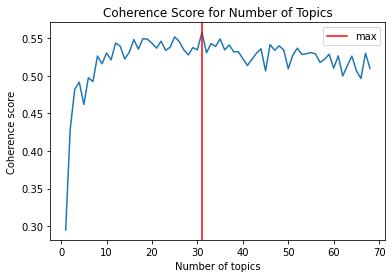

In [131]:
plt.plot(range(1,69),list_coherence)
plt.axvline(31,color='red',label='max')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.title('Coherence Score for Number of Topics')
plt.legend()

Exemple de schema dans un topic pour $n_{topic}^{optimal}$

In [133]:
#opti lda
lda = gensim.models.LdaMulticore(bow_corpus,num_topics=31,id2word=dictionary)

In [148]:
ex_list = [element[0] for element in lda.get_topic_terms(15)]
for element in ex_list:
    if element <= 640:
        print(data_s.iloc[element]['sentence'])
        print('- - - - -')

The sushi rotted on the counter unless it was put in the cooler, as the _ exposed it to contamination.
- - - - -
Victoria was disgusted because of the odor of Sarah, and _ did not want to be around them.
- - - - -
Donald was richer than Leslie was because companies had found oil on the property of _ .
- - - - -
Once in Poland, Dennis enjoyed the trip more than Jason because _ had a deeper understanding of the Polish language.
- - - - -
I couldn't control the moisture like I controlled the rain, because the _ was coming in everywhere.
- - - - -
Emptying the litter box was a dreaded chore for Adam while Lawrence didn't mind doing it. _ never tried to get someone else to handle it.
- - - - -
To overcome behavioural bias, we need to focus more on changing the conscious actions instead of the unconscious actions because the _ actions are voluntary.
- - - - -
I installed a new bird house outside above the ground, but had to prop it up higher away from my cat since the _ was too low.
- - - - 